In [810]:
%load_ext autoreload
%autoreload 1
%aimport src
%aimport src.utils
%aimport src.SdmIsmAnalysis
%aimport src.SimpleSynthesis

# display last assigned variable automatically
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

%matplotlib inline
from matplotlib.pyplot import *

from src.utils import mygrid
from src.BrirComparison import brir_comparison

import seaborn as sns
import polars as pl
import numpy as np
import scipy
from pathlib import Path
import os

import pyfar as pf

import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn
import sklearn.preprocessing, sklearn.linear_model, sklearn.pipeline
import sklearn.model_selection, sklearn.feature_selection, sklearn.metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in data

In [811]:
brirs = pf.io.read("listening_test_brirs.far")["brirs"]

time domain energy Signal:
(20, 5, 2) channels with 57600 samples @ 48000.0 Hz sampling rate and none FFT normalization

In [812]:
conditions = ['reference', 'lower_anchor', 'mid_anchor', 'bad', 'bad_filtered']

['reference', 'lower_anchor', 'mid_anchor', 'bad', 'bad_filtered']

In [813]:
trials_exp_order = [14, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 12, 15, 16, 17, 18, 19]

[14, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 12, 15, 16, 17, 18, 19]

In [814]:
df = pl.read_parquet("listening_test_ratings.parquet")
df = df.with_columns(
    exp_trial_idx = np.argmax(np.tile(df["trial"].to_numpy(), (18,1)).T == np.tile(np.array(trials_exp_order[2:]), (144, 1)), axis=1)
).with_columns(
    mean_nonextreme_mushra = pl.concat_list("bad", "mid_anchor", "bad_filtered").list.mean(),
    exp_trial_idx_end = pl.col("exp_trial_idx") - 17
)
with pl.Config(set_tbl_rows=40):
    display(df)

ID,trial,bad_filtered,bad,lower_anchor,mid_anchor,reference,timbre_dynamics,room_time,geometry,exp_trial_idx,mean_nonextreme_mushra,exp_trial_idx_end
i64,u32,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64
1,0,90,95,0,71,100,1,0,0,0,85.333333,-17
1,1,67,0,37,83,100,2,2,1,1,50.0,-16
1,2,75,89,0,45,100,1,1,0,2,69.666667,-15
1,3,86,72,49,81,100,2,1,1,3,79.666667,-14
1,4,68,50,0,82,100,1,2,1,4,66.666667,-13
1,5,71,60,23,71,100,2,0,2,5,67.333333,-12
1,6,51,12,0,86,100,2,0,0,6,49.666667,-11
1,7,67,23,57,77,100,2,2,0,7,55.666667,-10
1,8,51,35,0,76,100,2,0,0,8,54.0,-9


<Axes: xlabel='exp_trial_idx', ylabel='mean_nonextreme_mushra'>

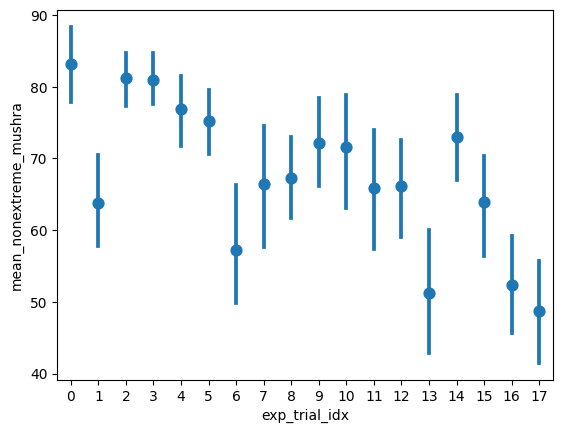

In [815]:
sns.pointplot(df, x="exp_trial_idx", y="mean_nonextreme_mushra", linestyle="none")

<Axes: xlabel='exp_trial_idx', ylabel='bad'>

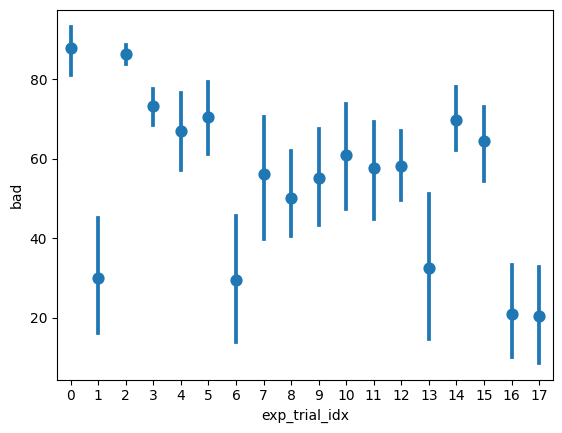

In [816]:
sns.pointplot(df, x="exp_trial_idx", y="bad", linestyle="none")

<Axes: xlabel='exp_trial_idx', ylabel='mid_anchor'>

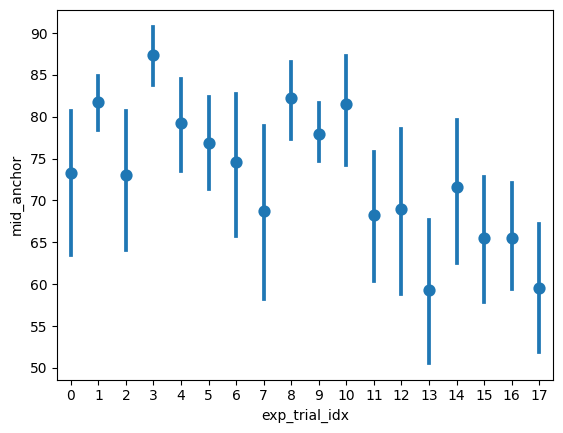

In [817]:
sns.pointplot(df, x="exp_trial_idx", y="mid_anchor", linestyle="none")

<Axes: xlabel='exp_trial_idx', ylabel='bad_filtered'>

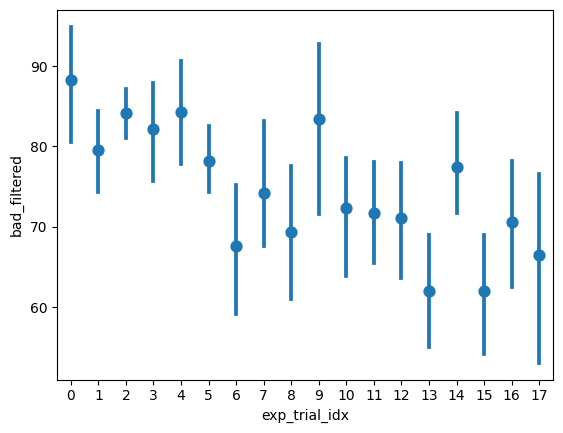

In [818]:
sns.pointplot(df, x="exp_trial_idx", y="bad_filtered", linestyle="none")

Seems to work!

# Remove MUSHRA Training Effect

In [819]:
mod = smf.ols("mean_nonextreme_mushra ~ 1 + exp_trial_idx", df)

In [820]:
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     mean_nonextreme_mushra   R-squared:                       0.249
Model:                                OLS   Adj. R-squared:                  0.244
Method:                     Least Squares   F-statistic:                     47.20
Date:                    Sat, 31 Aug 2024   Prob (F-statistic):           1.86e-10
Time:                            11:59:25   Log-Likelihood:                -562.80
No. Observations:                     144   AIC:                             1130.
Df Residuals:                         142   BIC:                             1136.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        79.0129      1.942     40.696      0.000      75.175      82.851
exp_trial_idx    -1.3395      0.195     -6.870      0.000      -1.725      -0.954
==============================================================================
Omnibus:                        7.401   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                6.702
Skew:                          -0.458   Prob(JB):                       0.0350
Kurtosis:                       2.472   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

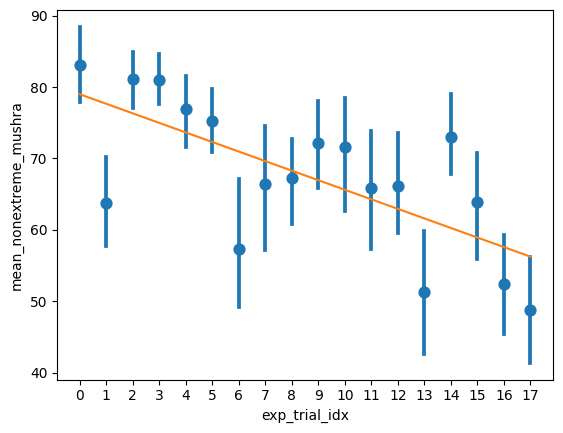

In [821]:
sns.pointplot(df, x="exp_trial_idx", y="mean_nonextreme_mushra", linestyle="none")
plot(df["exp_trial_idx"], res.predict(df["exp_trial_idx"].to_pandas()))

In [822]:
training_correction_coef = res.params.iloc[1]

-1.3394822841417318

In [823]:
df_training_correction = df.with_columns(
    pl.col("bad") - training_correction_coef*pl.col("exp_trial_idx_end"),
    pl.col("mid_anchor") - training_correction_coef*pl.col("exp_trial_idx_end"),
    pl.col("bad_filtered") - training_correction_coef*pl.col("exp_trial_idx_end"),
).with_columns(
    mean_nonextreme_mushra = pl.concat_list("bad", "mid_anchor", "bad_filtered").list.mean(),
)

ID,trial,bad_filtered,bad,lower_anchor,mid_anchor,reference,timbre_dynamics,room_time,geometry,exp_trial_idx,mean_nonextreme_mushra,exp_trial_idx_end
i64,u32,f64,f64,i64,f64,i64,i64,i64,i64,i64,f64,i64
1,0,67.228801,72.228801,0,48.228801,100,1,0,0,0,62.562135,-17
1,1,45.568283,-21.431717,37,61.568283,100,2,2,1,1,28.568283,-16
1,2,54.907766,68.907766,0,24.907766,100,1,1,0,2,49.574432,-15
1,3,67.247248,53.247248,49,62.247248,100,2,1,1,3,60.913915,-14
1,4,50.58673,32.58673,0,64.58673,100,1,2,1,4,49.253397,-13
…,…,…,…,…,…,…,…,…,…,…,…,…
9,15,69.642071,15.642071,45,69.642071,100,4,3,0,13,51.642071,-4
9,16,90.981553,55.981553,53,66.981553,100,2,3,2,14,71.314886,-3
9,17,75.321035,75.321035,59,71.321035,100,1,2,0,15,73.987702,-2


<Axes: xlabel='exp_trial_idx', ylabel='mean_nonextreme_mushra'>

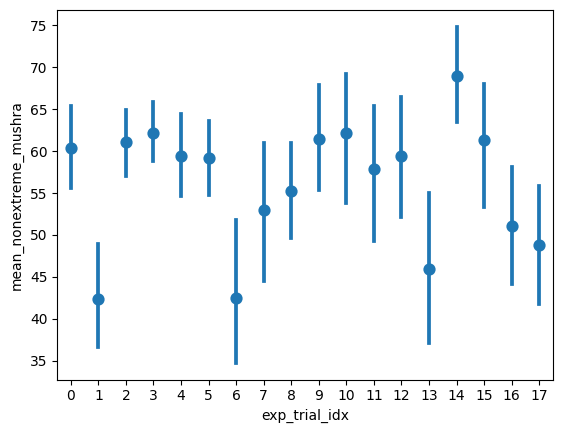

In [824]:
sns.pointplot(df_training_correction, x="exp_trial_idx", y="mean_nonextreme_mushra", linestyle="none")

<Axes: xlabel='exp_trial_idx', ylabel='bad'>

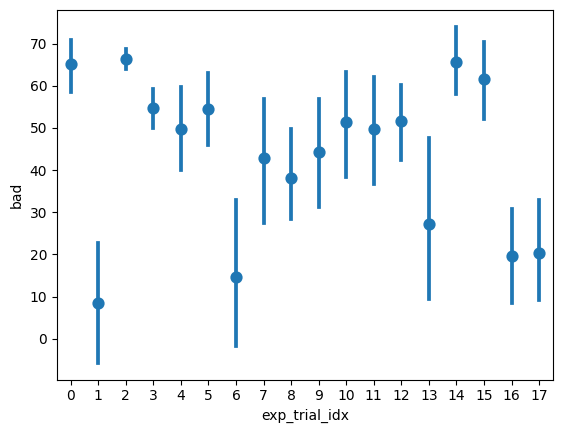

In [825]:
sns.pointplot(df_training_correction, x="exp_trial_idx", y="bad", linestyle="none")

<Axes: xlabel='exp_trial_idx', ylabel='mid_anchor'>

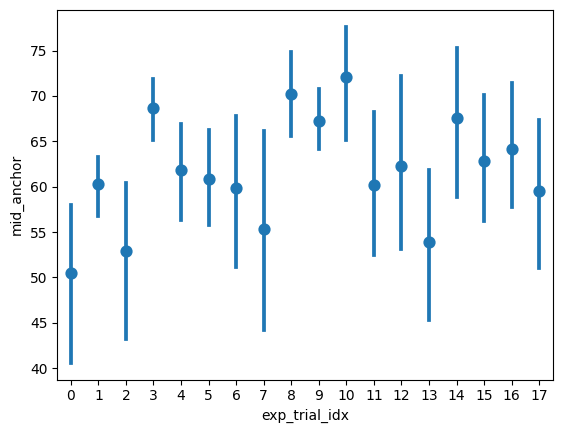

In [826]:
sns.pointplot(df_training_correction, x="exp_trial_idx", y="mid_anchor", linestyle="none")

<Axes: xlabel='exp_trial_idx', ylabel='bad_filtered'>

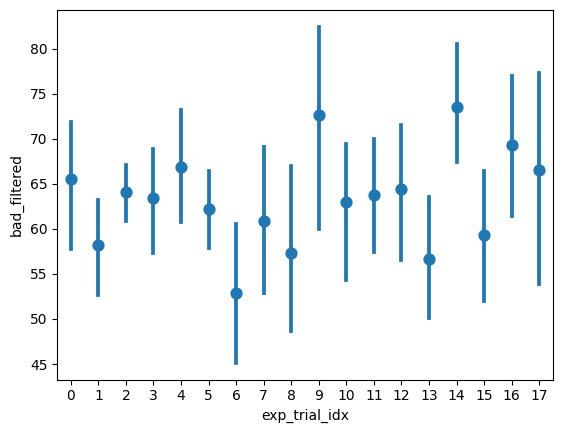

In [827]:
sns.pointplot(df_training_correction, x="exp_trial_idx", y="bad_filtered", linestyle="none")

### Overall Plot of Training Correction

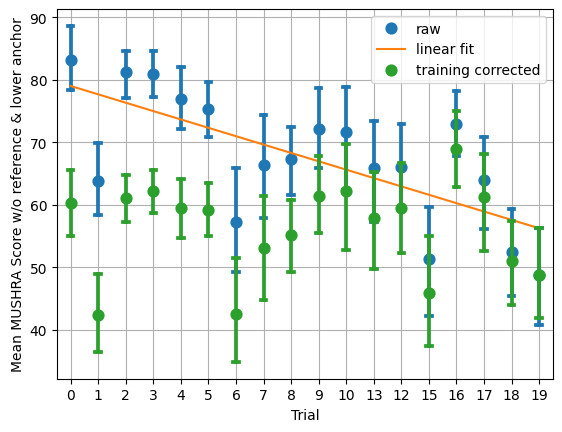

In [829]:
sns.pointplot(df, x="trial", y="mean_nonextreme_mushra", 
              linestyle="none", capsize=.2, order=trials_exp_order[2:], label="raw")
plot(df["exp_trial_idx"], res.predict(df["exp_trial_idx"].to_pandas()), label="linear fit")
sns.pointplot(df_training_correction, x="trial", y="mean_nonextreme_mushra", 
              linestyle="none", capsize=.2, order=trials_exp_order[2:], label="training corrected")
xlabel("Trial")
ylabel("Mean MUSHRA Score w/o reference & lower anchor")
grid()
savefig("../reports/figures/mushra-model-training-correction.pdf")

# Objective BRIR Metrics

In [20]:
conditions

['reference', 'lower_anchor', 'mid_anchor', 'bad', 'bad_filtered']

In [21]:
quality_metrics = [
    "xcorr_inv_add",
    "rmse_lin",
    "lag_rms",
    "level_rms",
    'misdistributed_energy',
    't30_rel_rms',
    'c20_rms',
    'iacc_rms',
    'lag_iacc_rms',
    'ild_rms',
    'spectral_difference',
]

['xcorr_inv_add',
 'rmse_lin',
 'lag_rms',
 'level_rms',
 'misdistributed_energy',
 't30_rel_rms',
 'c20_rms',
 'iacc_rms',
 'lag_iacc_rms',
 'ild_rms',
 'spectral_difference']

In [22]:
len(quality_metrics)

11

In [23]:
def get_quality_metrics(ref, sig):
    d = brir_comparison(ref, sig)
    # make everything positive with 0 being optimal
    d["xcorr_inv_add"] = -d["xcorr"] + 1
    d["rmse_lin"] = 10 ** (d["rmse"]/20)
    return {key: d[key] for key in quality_metrics}

In [24]:
arr = []
for i in range(20):
    for (j, stimulus) in list(enumerate(conditions))[1:]:
        arr.append({
            "trial": i,
            "rating_stimulus": stimulus,
            **get_quality_metrics(brirs[i:i+1, 0], brirs[i:i+1,j])
           })
df_obj = pl.DataFrame(arr)

trial,rating_stimulus,xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,"""lower_anchor""",0.641826,1.324687,19.697716,5.701226,0.394134,6.921932,6.634262,0.114329,37.0,8.829697,0.574585
0,"""mid_anchor""",0.428278,1.401546,14.0,0.653794,0.236794,5.134669,1.169803,0.240934,0.0,1.042128,0.303458
0,"""bad""",0.414685,1.416182,14.0,0.252213,0.223996,5.190902,1.497967,0.231215,0.0,0.404943,0.234854
0,"""bad_filtered""",0.4143,1.41583,14.0,0.268974,0.223957,5.192389,1.519186,0.233531,0.0,0.431738,0.238374
1,"""lower_anchor""",1.018991,1.24357,158.028478,3.017026,0.270213,0.093656,3.54913,0.00696,40.0,2.43274,0.554067
…,…,…,…,…,…,…,…,…,…,…,…,…
18,"""bad_filtered""",0.837227,1.431072,809.657026,2.892399,0.22272,0.68981,3.634063,0.176766,5.0,5.784226,0.838479
19,"""lower_anchor""",0.991099,1.195047,911.039242,3.848723,0.369571,0.815773,5.660349,0.068516,21.0,2.252533,0.960672
19,"""mid_anchor""",0.995615,1.396049,1001.066681,1.86025,0.343638,0.748354,6.524824,0.329578,7.0,3.598077,0.878632


# Join objective and subjective data

In [25]:
df_training_correction_unpivot = df_training_correction.select(
    ["ID", "trial", "bad_filtered", "bad", "mid_anchor", "lower_anchor"] # ohne lower_anchor?? beeinflusst sicherlich fits später negativ...
).melt(
    ["ID", "trial"]
).rename(dict(variable="rating_stimulus", value="mushra")).with_columns(
    pl.col("trial").cast(pl.datatypes.Int64)
)

ID,trial,rating_stimulus,mushra
i64,i64,str,f64
1,0,"""bad_filtered""",67.228801
1,1,"""bad_filtered""",45.568283
1,2,"""bad_filtered""",54.907766
1,3,"""bad_filtered""",67.247248
1,4,"""bad_filtered""",50.58673
…,…,…,…
9,15,"""lower_anchor""",45.0
9,16,"""lower_anchor""",53.0
9,17,"""lower_anchor""",59.0


In [26]:
df_joined = df_obj.join(df_training_correction_unpivot, on=["trial", "rating_stimulus"])

trial,rating_stimulus,xcorr_inv_add,rmse_lin,lag_rms,level_rms,misdistributed_energy,t30_rel_rms,c20_rms,iacc_rms,lag_iacc_rms,ild_rms,spectral_difference,ID,mushra
i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64
0,"""bad_filtered""",0.4143,1.41583,14.0,0.268974,0.223957,5.192389,1.519186,0.233531,0.0,0.431738,0.238374,1,67.228801
1,"""bad_filtered""",1.012449,1.582659,262.274665,1.951595,0.270509,0.078834,3.870877,0.007349,5.0,1.337358,0.42003,1,45.568283
2,"""bad_filtered""",0.325635,1.385418,13.509256,0.568302,0.202717,4.542825,1.78478,0.047765,1.0,0.839715,0.448315,1,54.907766
3,"""bad_filtered""",1.005222,1.454926,43.046487,0.527895,0.215475,0.55753,1.941025,0.057424,2.0,0.281874,0.423899,1,67.247248
4,"""bad_filtered""",0.786844,1.349981,3.0,0.102963,0.267258,0.68586,5.489906,0.049033,11.0,0.073246,0.677354,1,50.58673
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15,"""lower_anchor""",0.755521,1.152495,95.441081,6.199494,0.34136,0.102192,5.82694,0.051266,35.0,5.872025,0.710783,9,45.0
16,"""lower_anchor""",0.604627,1.364534,18.027756,4.188222,0.367903,4.200238,6.179465,0.275085,37.0,6.264445,0.727483,9,53.0
17,"""lower_anchor""",0.802946,1.053893,315.570911,9.721319,0.308672,0.429287,9.3712,0.024037,28.0,4.023185,0.480063,9,59.0


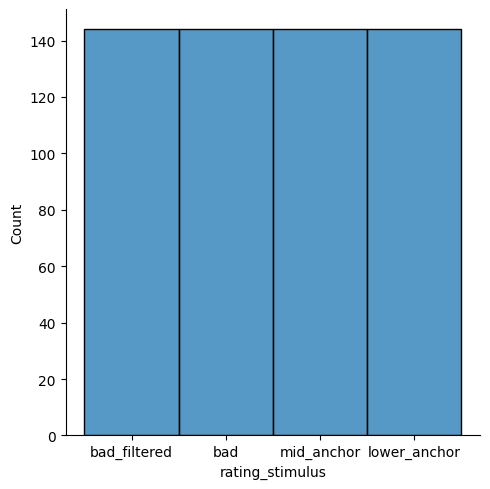

In [27]:
sns.displot(df_joined, x="rating_stimulus")

# Visualize

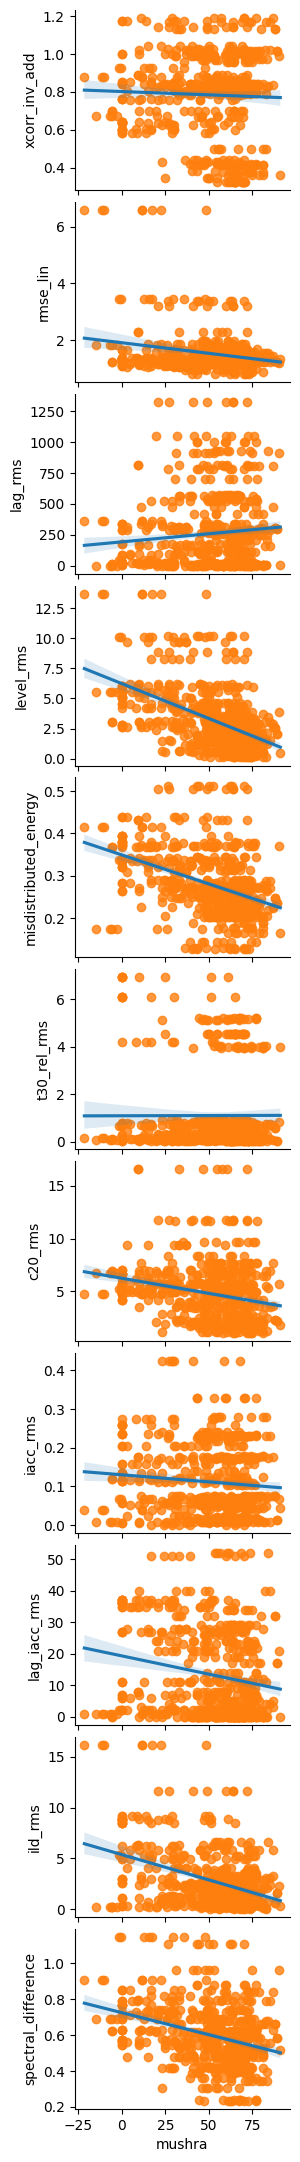

In [28]:
sns.pairplot(df_joined.to_pandas(), y_vars=quality_metrics, x_vars="mushra", 
             kind="reg", aspect=1.5, height=2, plot_kws={"scatter_kws": {"color": "C1"}})

Some are well correlated, yay!

# Fit model

# BELOW: OLD model fits

# Fit Model

In [341]:
df_joined_better = df_joined.filter(pl.col("mushra") > 50)

X = df_joined_better[quality_metrics]

y = df_joined_better["mushra"]

mushra
f64
67.228801
54.907766
67.247248
50.58673
54.926213
…
60.0
67.0
53.0


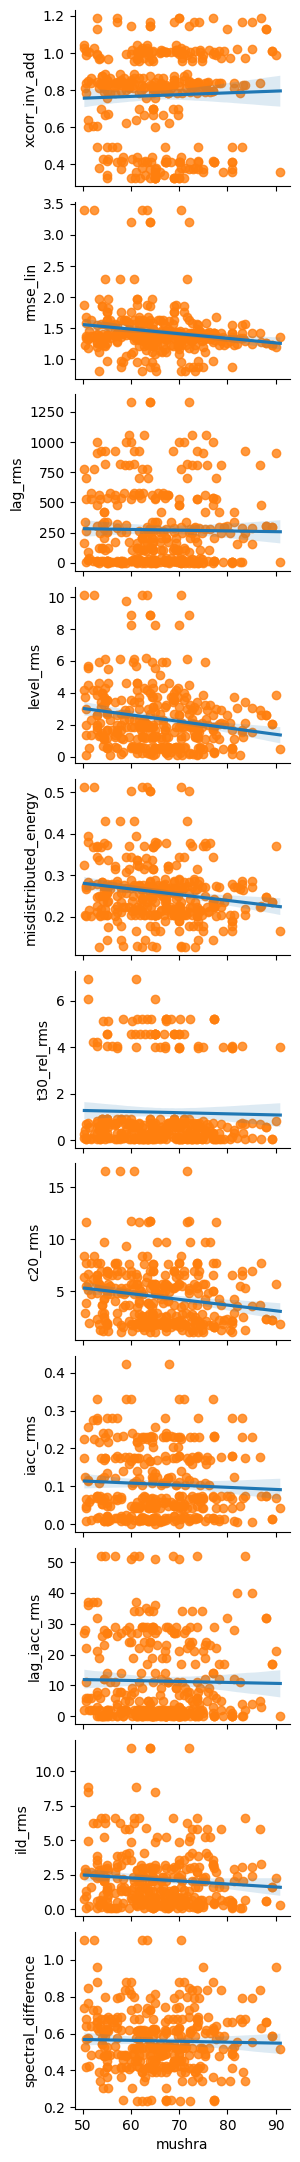

In [347]:
sns.pairplot(df_joined_better.to_pandas(), y_vars=quality_metrics, x_vars="mushra", 
             kind="reg", aspect=1.5, height=2, plot_kws={"scatter_kws": {"color": "C1"}})

# Baseline appraoch

In [342]:
pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    ('model', sklearn.linear_model.LassoCV()),
])

pipeline.fit(X,y)

pipeline.score(X, y)

0.033780842525593324

In [343]:
# Best alpha selected by LassoCV
best_alpha = pipeline.named_steps['model'].alpha_
print("Best alpha:", best_alpha)

# Coefficients of the model with the best alpha
print("Coefficients:", pipeline.named_steps['model'].coef_)

# Mean cross-validation MSE for the best alpha
best_score = -pipeline.named_steps['model'].mse_path_.mean(axis=1).min()
print("Best cross-validation MSE:", best_score)

Best alpha: 0.7291495922563391
Coefficients: [ 0.03190139 -0.31203584  0.         -0.46012787 -0.00949716 -0.
 -0.37422664 -0.          0.         -0.          0.        ]
Best cross-validation MSE: -79.81678804297566


In [344]:
X.columns

['xcorr_inv_add',
 'rmse_lin',
 'lag_rms',
 'level_rms',
 'misdistributed_energy',
 't30_rel_rms',
 'c20_rms',
 'iacc_rms',
 'lag_iacc_rms',
 'ild_rms',
 'spectral_difference']

In [345]:
y_pred = pipeline.predict(X);

Text(0, 0.5, 'predicted')

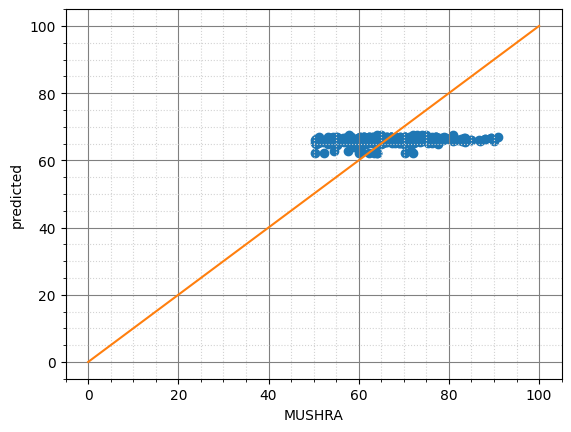

In [346]:
scatter(y, y_pred)
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")

# Try with full Standard Scaling

In [321]:
pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=True)),
    ('model', sklearn.linear_model.LassoCV()),
])
pipeline.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LassoCV())])

In [322]:
# Best alpha selected by LassoCV
best_alpha = pipeline.named_steps['model'].alpha_
print("Best alpha:", best_alpha)

# Coefficients of the model with the best alpha
print("Coefficients:", pipeline.named_steps['model'].coef_)

# Mean cross-validation MSE for the best alpha
best_score = -pipeline.named_steps['model'].mse_path_.mean(axis=1).min()
print("Best cross-validation MSE:", best_score)

Best alpha: 0.877555375383265
Coefficients: [ 0.         -1.09694426  2.19285532 -7.06995891 -2.0224012   0.29998909
 -0.07448899 -0.          1.52782639  0.         -0.        ]
Best cross-validation MSE: -296.01331435129555


In [323]:
X.columns

['xcorr_inv_add',
 'rmse_lin',
 'lag_rms',
 'level_rms',
 'misdistributed_energy',
 't30_rel_rms',
 'c20_rms',
 'iacc_rms',
 'lag_iacc_rms',
 'ild_rms',
 'spectral_difference']

In [324]:
y_pred = pipeline.predict(X);

Text(0, 0.5, 'predicted')

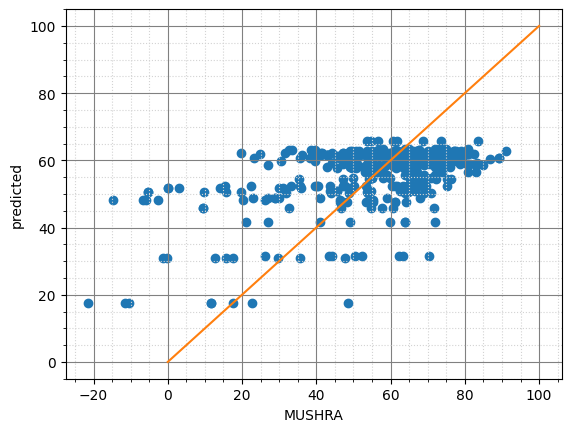

In [325]:
scatter(y, y_pred)
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")

Not different?

TODO find faster scoring for pipeline

TODO I'm not happy with this, can we somehow improve it?

# Fit on means

In [348]:
df_joined_means = df_joined_better.group_by(["trial", "rating_stimulus"]).mean()
y_means = df_joined_means["mushra"]
X_means = df_joined_means[quality_metrics];

In [349]:
pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    ('model', sklearn.linear_model.LassoCV()),
])

pipeline.fit(X_means,y_means)

pipeline.score(X_means,y_means)

0.29214056529032606

Higher R^2 with means, obviously, since it doesn't include unfittable ID variations.

In [350]:
list(zip(quality_metrics, pipeline.named_steps['model'].coef_))

[('xcorr_inv_add', 1.413355443637786),
 ('rmse_lin', -0.39694478502818076),
 ('lag_rms', 0.6116775137838071),
 ('level_rms', -1.112733408525389),
 ('misdistributed_energy', -0.5047189601554165),
 ('t30_rel_rms', -0.0),
 ('c20_rms', -0.9321208716782734),
 ('iacc_rms', -0.0),
 ('lag_iacc_rms', 0.0),
 ('ild_rms', -0.10439943791275541),
 ('spectral_difference', 0.0)]

In [351]:
pruned_quality_metrics = ['xcorr_inv_add',
 'rmse_lin',
 'lag_rms',
 'level_rms',
 'misdistributed_energy',
 'ild_rms',
 'spectral_difference']

['xcorr_inv_add',
 'rmse_lin',
 'lag_rms',
 'level_rms',
 'misdistributed_energy',
 'ild_rms',
 'spectral_difference']

Text(0, 0.5, 'predicted')

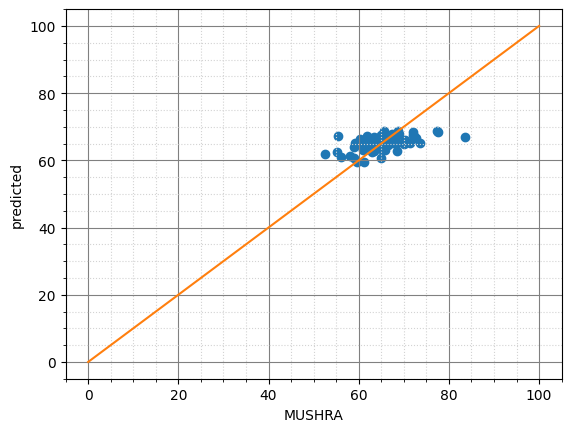

In [352]:
scatter(y_means, pipeline.predict(X_means))
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")

# Ridge on means

In [353]:
pipeline = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    ('model', sklearn.linear_model.RidgeCV()),
])

pipeline.fit(X_means,y_means)

pipeline.score(X_means,y_means)

0.32085784598850586

In [354]:
list(zip(quality_metrics, pipeline.named_steps['model'].coef_))

[('xcorr_inv_add', 1.3452824173921625),
 ('rmse_lin', -0.6145848244720484),
 ('lag_rms', 1.0573984620437344),
 ('level_rms', -1.1393502104722986),
 ('misdistributed_energy', -0.6852042561747007),
 ('t30_rel_rms', -0.10960233345260509),
 ('c20_rms', -1.0802416578078764),
 ('iacc_rms', -0.07881587097707315),
 ('lag_iacc_rms', 0.20380066852948564),
 ('ild_rms', -0.5635116424009917),
 ('spectral_difference', 0.3529381192965404)]

Text(0, 0.5, 'predicted')

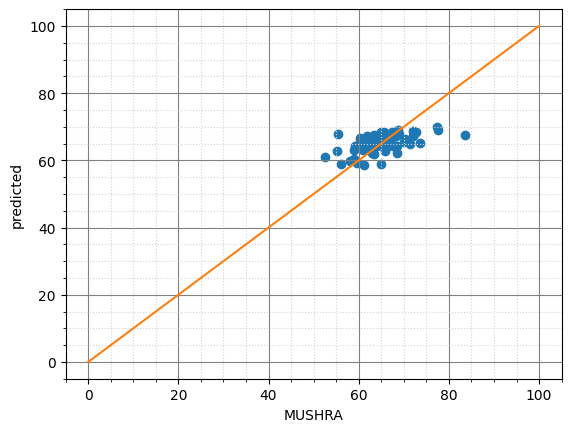

In [355]:
scatter(y_means, pipeline.predict(X_means))
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")

Ridge is just like Lasso here but less sparse. Prefer lasso. 

# New stuff below

First check distribution of MUSHRA scores

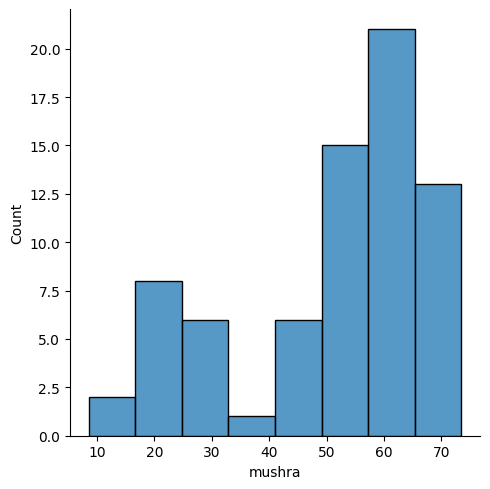

In [123]:
df_here0 = df_joined.group_by(["trial", "rating_stimulus"], maintain_order=True).mean()
X = df_here0[quality_metrics]
sns.displot(df_here0, x="mushra")

Non-even distribution means we should use stratified cross-validation. 

# Filter Features

Needed to remove complexity from quadratic fit later

In [753]:
pipeline = sklearn.pipeline.Pipeline([
    #('poly', sklearn.preprocessing.PolynomialFeatures(0)),
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    ('model', sklearn.linear_model.Lasso(alpha=3)),
])

df_here = df_joined.group_by(["trial", "rating_stimulus"], maintain_order=True).mean()
X = df_here[quality_metrics]
y = df_here["mushra"]

pipeline.fit(X,y)

pipeline.score(X,y)

0.4880065801947575

In [754]:
list(zip(quality_metrics, pipeline.named_steps['model'].coef_))

[('xcorr_inv_add', 0.0),
 ('rmse_lin', 0.0),
 ('lag_rms', 2.025504762437973),
 ('level_rms', -7.040191164610582),
 ('misdistributed_energy', -2.349827138557372),
 ('t30_rel_rms', -0.0),
 ('c20_rms', -0.0),
 ('iacc_rms', -0.0),
 ('lag_iacc_rms', -0.0),
 ('ild_rms', -0.2909659845981921),
 ('spectral_difference', -0.0)]

In [755]:
# remove useless metrics
# pruned_quality_metrics = [
#  'xcorr_inv_add', # positive influence, bad correlation
#  'rmse_lin', # positive influence but hypothesized to be good
#  'lag_rms', # positive
#  'level_rms', # use
#  'misdistributed_energy', # use
#  #'t30_rel_rms',
#  #'c20_rms',
#  #'iacc_rms',
#  #'lag_iacc_rms',
#  'ild_rms',# use
#  'spectral_difference']
pruned_quality_metrics = np.array(quality_metrics)[pipeline.named_steps['model'].coef_ != 0]
# manual add
pruned_quality_metrics = np.concatenate((pruned_quality_metrics, ["rmse_lin"])) # this is it

array(['lag_rms', 'level_rms', 'misdistributed_energy', 'ild_rms',
       'rmse_lin'], dtype='<U21')

Text(0, 0.5, 'predicted')

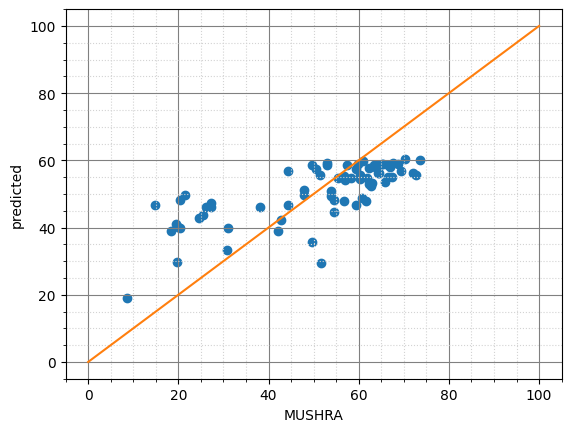

In [756]:
scatter(y, pipeline.predict(X))
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")

# Quad Ridge, Selected Features

In [757]:
cv = sklearn.model_selection.RepeatedKFold(n_splits=72//3, n_repeats=3, random_state=9219812)

RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812)

In [773]:
alphas = np.logspace(-1, 1, 20)

array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])

In [774]:
pipeline = sklearn.pipeline.Pipeline([
    ('poly', sklearn.preprocessing.PolynomialFeatures(2)),
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    # ('model', sklearn.linear_model.RidgeCV(
    #     alphas=alphas, 
    #     cv=None,
    #     scoring='neg_mean_absolute_error',
    #     store_cv_results=True,
    # )),
    ('model', sklearn.linear_model.Ridge(alpha=1)),
])

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=1))])

In [775]:
df_here = df_joined.group_by(["trial", "rating_stimulus"], maintain_order=True).mean()
X = df_here[pruned_quality_metrics]
y = df_here["mushra"];

In [776]:
hyperparam_optimization = sklearn.model_selection.GridSearchCV(
    pipeline,
    dict(model__alpha=alphas),
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=False
).fit(X,y)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Ridge(alpha=1))]),
             param_grid={'model__alpha': array([ 0.1       ,  0.1274275 ,  0.16237767,  0.20691381,  0.26366509,
        0.33598183,  0.42813324,  0.54555948,  0.6951928 ,  0.88586679,
        1.12883789,  1.43844989,  1.83298071,  2.33572147,  2.97635144,
        3.79269019,  4.83293024,  6.15848211,  7.8475997 , 10.        ])},
             scoring='neg_mean_absolute_error')

In [777]:
hyperparam_optimization.best_params_

{'model__alpha': 0.8858667904100825}

In [778]:
hyperparam_optimization.best_score_

-7.650380730340324

In [779]:
pipeline_best = hyperparam_optimization.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=0.8858667904100825))])

In [780]:
pipeline_best.score(X,y)

0.7709322906874538

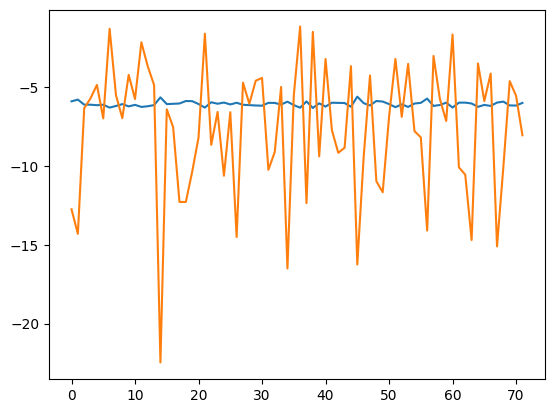

In [781]:
r = sklearn.model_selection.cross_validate(pipeline_best, X, y, 
    cv=cv,
    return_train_score=True, 
    scoring='neg_mean_absolute_error'
);

plot(r["train_score"])
plot(r["test_score"])
#ylim(-1, 1)

In [782]:
np.mean(r["test_score"])

-7.650380730340324

In [783]:
np.std(r["test_score"])

4.190983378551988

In [784]:
np.mean(r["train_score"])

-6.087678397042168

In [785]:
# True if overfitting
np.mean(r["train_score"]) > np.mean(r["test_score"]) + np.std(r["test_score"])

False

In [800]:
mae = sklearn.metrics.mean_absolute_error(y, pipeline_best.predict(X))

6.101275875909835

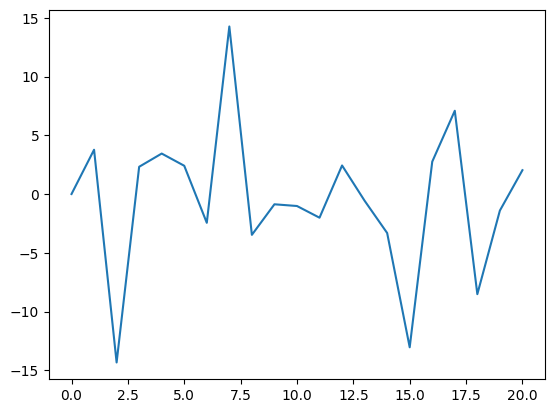

In [787]:
plot(pipeline_best.named_steps["model"].coef_)

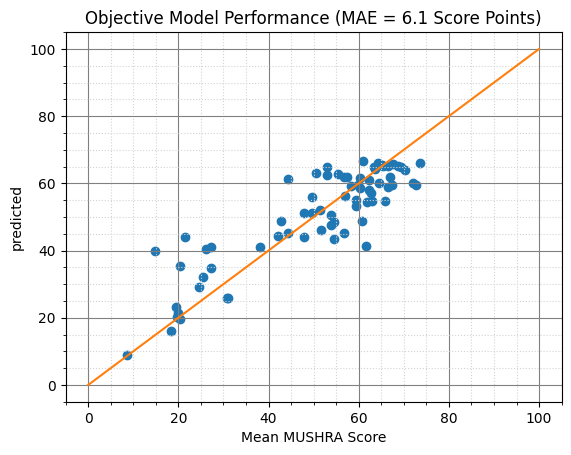

In [807]:
scatter(y, pipeline_best.predict(X))
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("Mean MUSHRA Score")
ylabel("predicted")
title(f"Objective Model Performance (MAE = {mae:0.1f} Score Points)")
savefig("../reports/figures/objective_model_performance.pdf")

In [808]:
from pickle import dump
with open("objective_model.pkl", "wb") as file:
    dump(pipeline_best, file, protocol=5)

In [809]:
np.save("objective_model_features.npy", pruned_quality_metrics)

# Quadratic Ridge, Pruned Features

In [265]:
cv = sklearn.model_selection.RepeatedKFold(n_splits=72//3, n_repeats=3, random_state=9219812)

RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812)

In [266]:
alphas = np.logspace(-1, 2, 20)

array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])

In [267]:
pipeline = sklearn.pipeline.Pipeline([
    ('poly', sklearn.preprocessing.PolynomialFeatures(2)),
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    # ('model', sklearn.linear_model.RidgeCV(
    #     alphas=alphas, 
    #     cv=None,
    #     scoring='neg_mean_absolute_error',
    #     store_cv_results=True,
    # )),
    ('model', sklearn.linear_model.Ridge(alpha=1)),
])

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=1))])

In [269]:
df_here = df_joined.group_by(["trial", "rating_stimulus"], maintain_order=True).mean()
X = df_here[pruned_quality_metrics]
y = df_here["mushra"];

In [270]:
hyperparam_optimization = sklearn.model_selection.GridSearchCV(
    pipeline,
    dict(model__alpha=alphas),
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=False
).fit(X,y)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Ridge(alpha=1))]),
             param_grid={'model__alpha': array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])},
             scoring='neg_mean_absolute_error')

In [271]:
hyperparam_optimization.best_params_

{'model__alpha': 1.8329807108324356}

In [272]:
hyperparam_optimization.best_score_

-8.153024029709112

In [273]:
pipeline_best = hyperparam_optimization.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=1.8329807108324356))])

In [274]:
pipeline_best.score(X,y)

0.7769360186782941

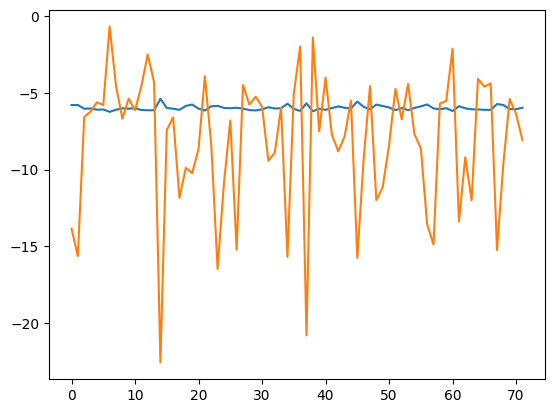

In [275]:
r = sklearn.model_selection.cross_validate(pipeline_best, X, y, 
    cv=cv,
    return_train_score=True, 
    scoring='neg_mean_absolute_error'
);

plot(r["train_score"])
plot(r["test_score"])
#ylim(-1, 1)

In [276]:
np.mean(r["train_score"])

-5.988509224933196

In [277]:
np.mean(r["test_score"])

-8.153024029709112

In [278]:
np.std(r["test_score"])

4.404354622965153

In [279]:
# True if overfitting
np.mean(r["train_score"]) > np.mean(r["test_score"]) + np.std(r["test_score"])

False

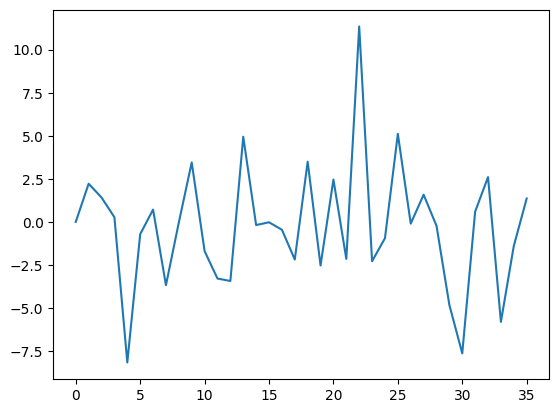

In [280]:
plot(pipeline_best.named_steps["model"].coef_)

Text(0, 0.5, 'predicted')

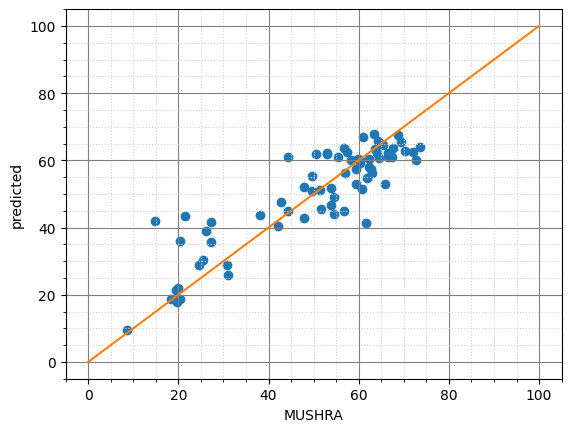

In [281]:
scatter(y, pipeline_best.predict(X))
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")

This learns quite a bit better than with all features

# Try Quadratic Lasso on Quadratic Features

In [282]:
cv = sklearn.model_selection.RepeatedKFold(n_splits=72//3, n_repeats=3, random_state=9219812)

RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812)

In [284]:
pipeline = sklearn.pipeline.Pipeline([
    ('poly', sklearn.preprocessing.PolynomialFeatures(2)),
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    # ('model', sklearn.linear_model.RidgeCV(
    #     alphas=alphas, 
    #     cv=None,
    #     scoring='neg_mean_absolute_error',
    #     store_cv_results=True,
    # )),
    ('model', sklearn.linear_model.Lasso(alpha=1)),
])

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Lasso(alpha=1))])

In [285]:
df_here = df_joined.group_by(["trial", "rating_stimulus"], maintain_order=True).mean()
X = df_here[quality_metrics]
y = df_here["mushra"];

In [299]:
alphas = np.logspace(0, 2, 3)

array([  1.,  10., 100.])

In [300]:
hyperparam_optimization = sklearn.model_selection.GridSearchCV(
    pipeline,
    dict(model__alpha=alphas),
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=False
).fit(X,y)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Lasso(alpha=1))]),
             param_grid={'model__alpha': array([  1.,  10., 100.])},
             scoring='neg_mean_absolute_error')

In [301]:
hyperparam_optimization.best_params_

{'model__alpha': 1.0}

In [302]:
hyperparam_optimization.best_score_

-8.545994400274944

In [303]:
pipeline_best = hyperparam_optimization.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Lasso())])

In [304]:
pipeline_best.score(X,y)

0.6892397322242019

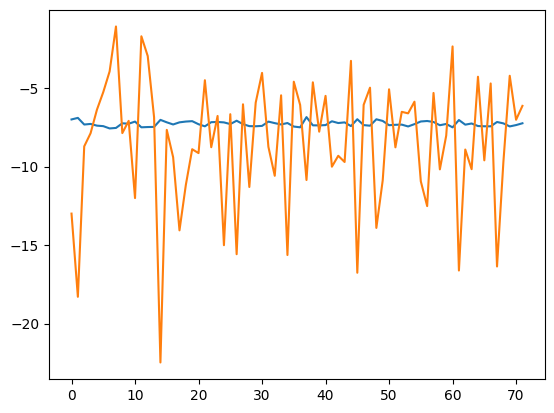

In [305]:
r = sklearn.model_selection.cross_validate(pipeline_best, X, y, 
    cv=cv,
    return_train_score=True, 
    scoring='neg_mean_absolute_error'
);

plot(r["train_score"])
plot(r["test_score"])
#ylim(-1, 1)

In [306]:
np.mean(r["train_score"])

-7.2804233642047445

In [307]:
np.mean(r["test_score"])

-8.545994400274944

In [308]:
np.std(r["test_score"])

4.170895310255989

In [309]:
# True if overfitting
np.mean(r["train_score"]) > np.mean(r["test_score"]) + np.std(r["test_score"])

False

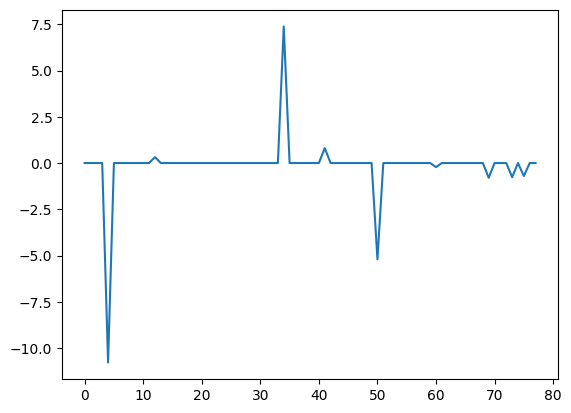

In [310]:
plot(pipeline_best.named_steps["model"].coef_)

Text(0, 0.5, 'predicted')

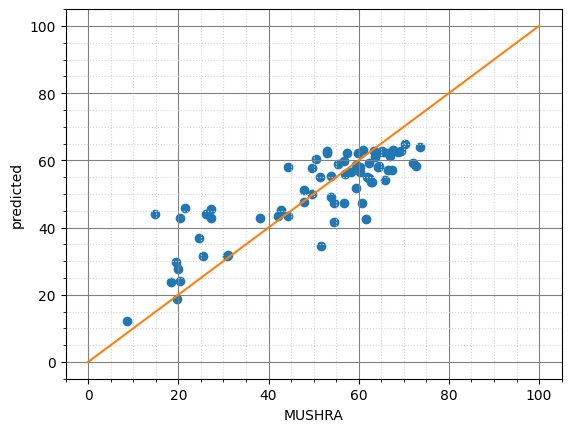

In [311]:
scatter(y, pipeline_best.predict(X))
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")

Doesn't converge well...

# Remove Features

In [432]:
cv = sklearn.model_selection.RepeatedKFold(n_splits=72//3, n_repeats=3, random_state=9219812)

RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812)

In [433]:
pipeline = sklearn.pipeline.Pipeline([
    ('poly', sklearn.preprocessing.PolynomialFeatures(2)),
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    #('rfe', sklearn.feature_selection.RFE(sklearn.linear_model.Ridge(alpha=1))),
    ('model', sklearn.linear_model.Ridge(alpha=1)),
])

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=1))])

In [434]:
df_here = df_joined.group_by(["trial", "rating_stimulus"], maintain_order=True).mean()
X = df_here[quality_metrics]
y = df_here["mushra"];

In [435]:
alphas = np.logspace(-1, 2, 20)

array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])

In [436]:
hyperparam_optimization = sklearn.model_selection.GridSearchCV(
    pipeline,
    dict(model__alpha=alphas, 
         #rfe__estimator__alpha=alphas
        ),
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=False
).fit(X,y)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Ridge(alpha=1))]),
             param_grid={'model__alpha': array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])},
             scoring='neg_mean_absolute_error')

In [437]:
hyperparam_optimization.best_params_

{'model__alpha': 33.59818286283781}

In [438]:
hyperparam_optimization.best_score_

-9.0937894648161

In [439]:
pipeline_best = hyperparam_optimization.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=33.59818286283781))])

In [440]:
pipeline_best.score(X,y)

0.6949532297310972

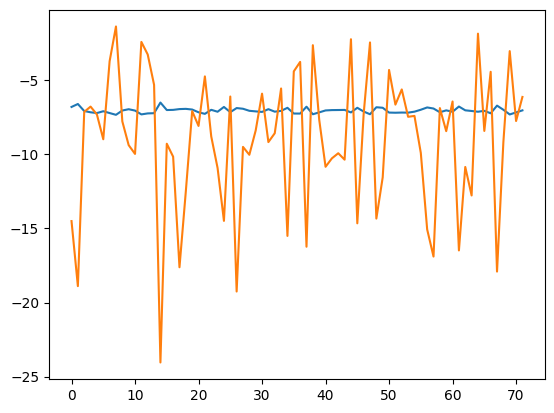

In [441]:
r = sklearn.model_selection.cross_validate(pipeline_best, X, y, 
    cv=cv,
    return_train_score=True, 
    scoring='neg_mean_absolute_error'
);

plot(r["train_score"])
plot(r["test_score"])
#ylim(-1, 1)

In [442]:
np.mean(r["train_score"])

-7.04657054113761

In [443]:
np.mean(r["test_score"])

-9.0937894648161

In [444]:
np.std(r["test_score"])

4.720595164271287

In [445]:
# True if overfitting
np.mean(r["train_score"]) > np.mean(r["test_score"]) + np.std(r["test_score"])

False

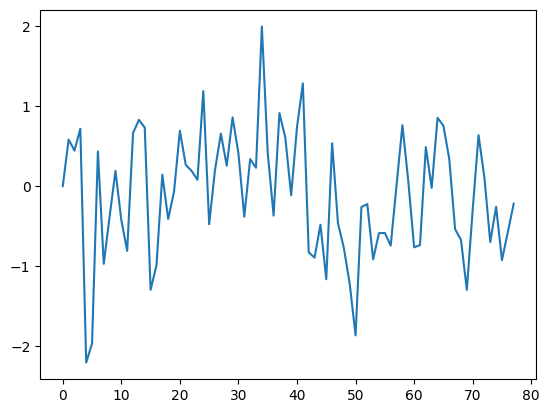

In [446]:
plot(pipeline_best.named_steps["model"].coef_)

Text(0, 0.5, 'predicted')

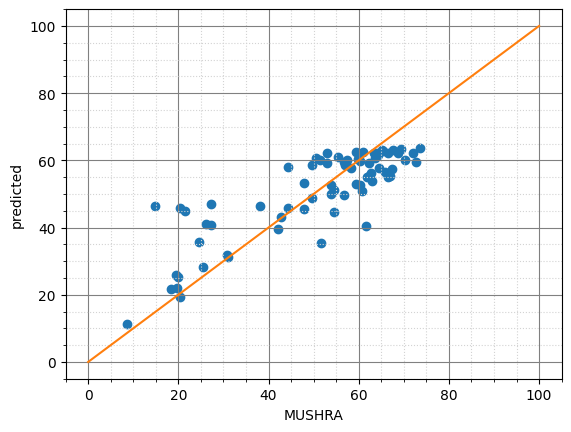

In [447]:
scatter(y, pipeline_best.predict(X))
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")

## Apply RFE

In [448]:
#Here is where you can get the output of intermediate steps
Xt = X

for name, transform in pipeline_best.steps[:-1]:
    if transform is not None:
        Xt = transform.transform(Xt)

In [449]:
Xt.shape

(72, 78)

In [474]:
rfe = sklearn.feature_selection.RFE(
    pipeline_best["model"],
    n_features_to_select=30,
    step=.3,
    #importance_getter="named_steps.model.coef_"
).fit(Xt,y)

RFE(estimator=Ridge(alpha=2.636650898730358), n_features_to_select=30, step=0.3)

In [475]:
rfe.n_features_

30

In [476]:
rfe.support_

array([False,  True, False, False,  True, False, False,  True, False,
       False, False,  True, False,  True, False,  True,  True, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False,  True, False,  True, False, False, False,
        True,  True, False, False,  True,  True, False, False,  True,
        True, False, False, False,  True, False,  True,  True, False,
       False,  True,  True,  True, False,  True,  True, False,  True,
       False, False, False,  True, False, False])

## New pipeline

In [477]:
pipeline_rfe = sklearn.pipeline.Pipeline([
    ('poly', sklearn.preprocessing.PolynomialFeatures(2)),
    ('rfe', rfe),
    ('scaler', sklearn.preprocessing.StandardScaler(with_mean=False)),
    ('model', sklearn.linear_model.Ridge(alpha=1)),
])

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('rfe',
                 RFE(estimator=Ridge(alpha=2.636650898730358),
                     n_features_to_select=30, step=0.3)),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=1))])

In [478]:
alphas = np.logspace(-1, 2, 20)

array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])

In [479]:
hyperparam_optimization = sklearn.model_selection.GridSearchCV(
    pipeline_rfe,
    dict(model__alpha=alphas),
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=False
).fit(X,y)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=24, random_state=9219812),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('rfe',
                                        RFE(estimator=Ridge(alpha=2.636650898730358),
                                            n_features_to_select=30,
                                            step=0.3)),
                                       ('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('model', Ridge(alpha=1))]),
             param_grid={'model__alpha': array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])},
             scoring='neg_mean_absolute_error')

In [480]:
hyperparam_optimization.best_params_

{'model__alpha': 1.8329807108324356}

In [481]:
hyperparam_optimization.best_score_

-10.681518056872765

In [482]:
pipeline_best = hyperparam_optimization.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('rfe',
                 RFE(estimator=Ridge(alpha=2.636650898730358),
                     n_features_to_select=30, step=0.3)),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge(alpha=1.8329807108324356))])

In [483]:
pipeline_best.score(X,y)

0.6854275933664994

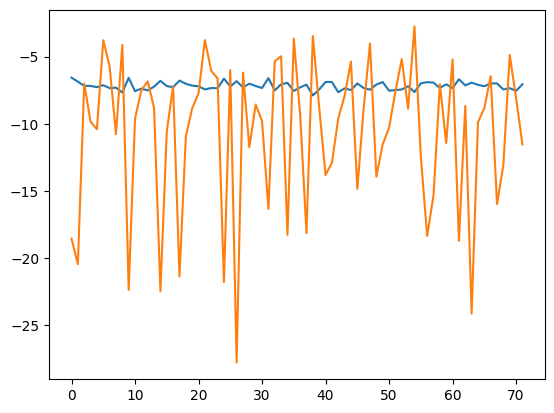

In [484]:
r = sklearn.model_selection.cross_validate(pipeline_best, X, y, 
    cv=cv,
    return_train_score=True, 
    scoring='neg_mean_absolute_error'
);

plot(r["train_score"])
plot(r["test_score"])
#ylim(-1, 1)

In [485]:
np.mean(r["train_score"])

-7.192615631522999

In [486]:
np.mean(r["test_score"])

-10.681518056872765

In [487]:
np.std(r["test_score"])

5.646787584105734

In [488]:
# True if overfitting
np.mean(r["train_score"]) > np.mean(r["test_score"]) + np.std(r["test_score"])

False

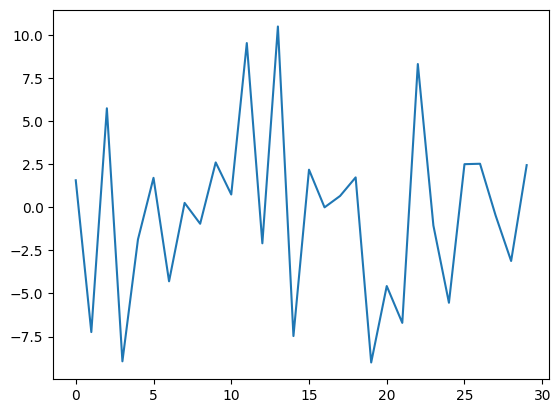

In [489]:
plot(pipeline_best.named_steps["model"].coef_)

Text(0, 0.5, 'predicted')

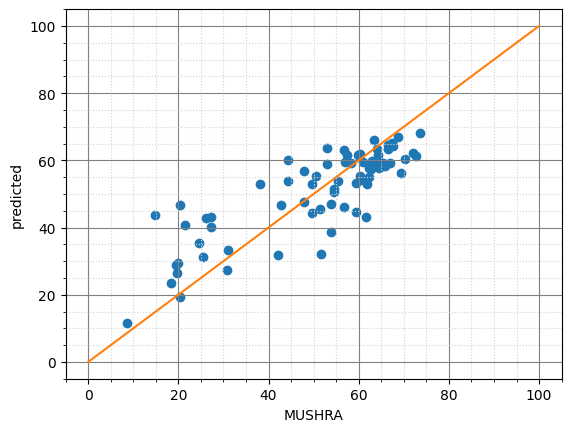

In [490]:
scatter(y, pipeline_best.predict(X))
plot([0, 100], [0, 100], color="C1")
mygrid()
xlabel("MUSHRA")
ylabel("predicted")